#### OOD GANS Walkthrough

In [24]:
import sys
sys.path.insert(0, '../')

In [25]:
from config import *
from dataset import MNIST,CIFAR10, MNIST_SUB
from models.mnist_cnn import MNISTCNN
from models.hparam import HParam
from models.gans import *
from models.dc_gan_model import *
from utils import *
# from trainer import train # Not needed for OOD GANS

# import autoreload code
# %load_ext autoreload
# %autoreload 2

### Dataset Processing


In [26]:
mnist_tri_set, mnist_val_set, mnist_tri_loader, mnist_val_loader = MNIST(128, 32, 2, True)
cifar_tri_set, cifar_val_set , cifar_tri_loader, cifar_val_loader = CIFAR10(128, 32)
# USE MNIST SUBSAMPLES
ind_idx = [0,2,3,6,8]
ood_idx = [1,7]
# TODO: Use classifier on 1,4,5,7,9, check wass loss
# test_idx = [4,5,9]
mnist_dset_dict = MNIST_SUB(batch_size=128, val_batch_size=64, idx_ind=ind_idx, idx_ood=ood_idx, shuffle=True)
# TODO: Show dataset statistics and sample images.

Files already downloaded and verified
Files already downloaded and verified


### Basics

In [33]:
sample_0, y_0 = mnist_tri_set.__getitem__(0)
sample_1, y_1 = mnist_tri_set.__getitem__(1)
sample_x, y_x = mnist_tri_set.__getitem__(6)
sample_x1, y_x1 = mnist_tri_set.__getitem__(1839)

ic(y_x1)
ic(y_x)
ic(y_0)
ic(y_1)

ic(get_dist_metric(sample_x, sample_x1, 1, DIST_TYPE.EUC))
ic(get_dist_metric(sample_1, sample_0, 1, DIST_TYPE.EUC))

ic| y_x1: 1
ic| y_x: 1
ic| y_0: 5
ic| y_1: 0
ic| get_dist_metric(sample_x, sample_x1, 1, DIST_TYPE.EUC): tensor(7.1115)
ic| get_dist_metric(sample_1, sample_0, 1, DIST_TYPE.EUC): tensor(9.3612)


tensor(9.3612)

### Original GANS Implementation

In [ ]:
D = discriminator(gan_type=GAN_TYPE.NAIVE).to(DEVICE)
G = generator().to(DEVICE)
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
gan_trainer(mnist_tri_loader, D, G, D_solver, G_solver,
            discriminator_loss, generator_loss, gan_type=GAN_TYPE.NAIVE)

### Original Deep Convolutional GAN Implementation

In [ ]:
D = dc_discriminator().to(DEVICE)
G = dc_generator().to(DEVICE)
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
gan_trainer(mnist_tri_loader, D, G, D_solver, G_solver,
            discriminator_loss, generator_loss, gan_type=GAN_TYPE.NAIVE)

### OOD GAN Sample Training with Logger



Iter: 0, D: 0.8443, G:0.2941


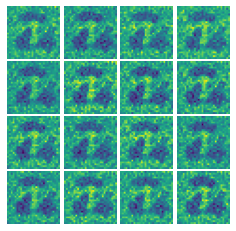


Iter: 100, D: -2.051, G:0.4788


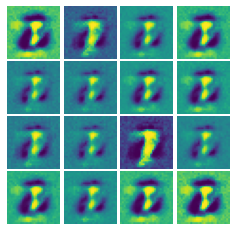


Iter: 200, D: -2.482, G:0.5028


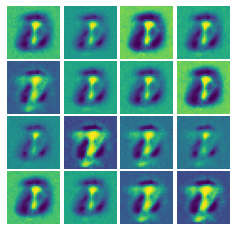


Iter: 300, D: -2.998, G:1.041


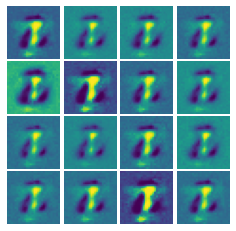


Iter: 400, D: -2.524, G:0.2923


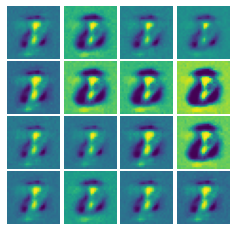


Iter: 500, D: -2.848, G:0.686


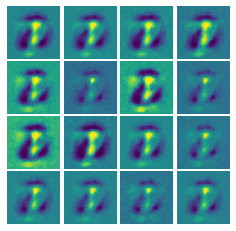


Iter: 600, D: -3.103, G:1.143


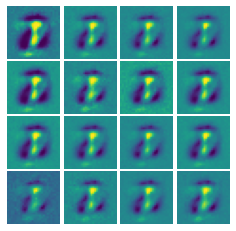


Iter: 700, D: -2.967, G:0.4773


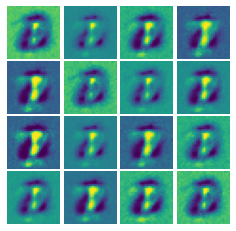


Iter: 800, D: -3.077, G:0.7401


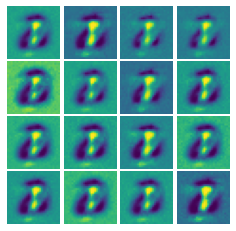


Iter: 900, D: -3.495, G:0.8282


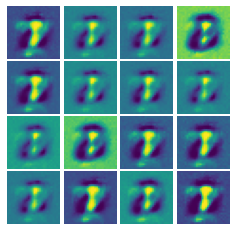


Iter: 1000, D: -3.592, G:0.9921


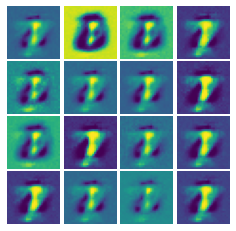


Iter: 1100, D: -4.105, G:1.366


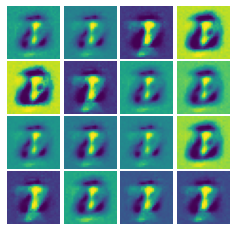


Iter: 1200, D: -4.761, G:1.361


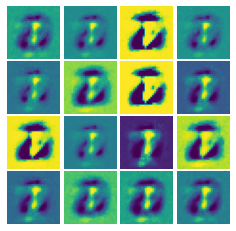


Iter: 1300, D: -5.296, G:2.309


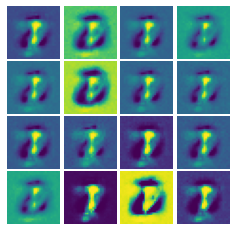


Iter: 1400, D: -5.046, G:1.85


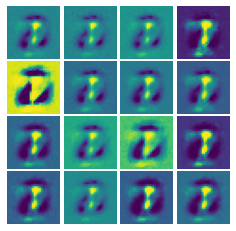


Iter: 1500, D: -5.675, G:2.141


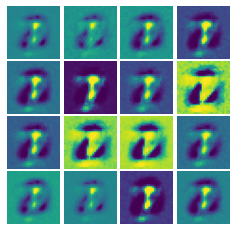


Iter: 1600, D: -6.324, G:2.282


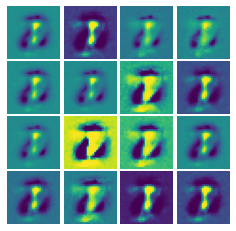


Iter: 1700, D: -7.179, G:2.812


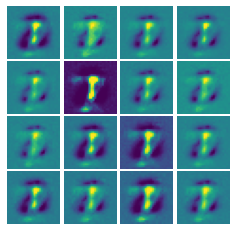


Iter: 1800, D: -7.505, G:3.246


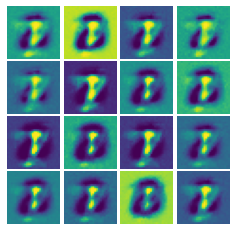


Iter: 1900, D: -5.567, G:1.249


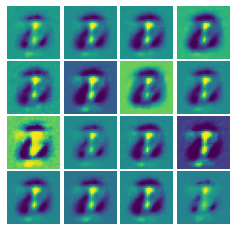


Iter: 2000, D: -5.789, G:1.607


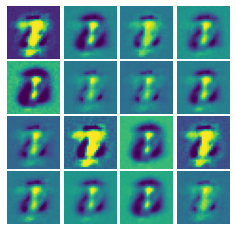


Iter: 2100, D: -6.809, G:2.78


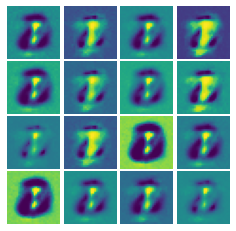


Iter: 2200, D: -7.756, G:3.374


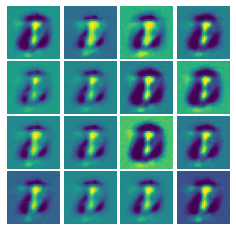


Iter: 2300, D: -6.118, G:1.909


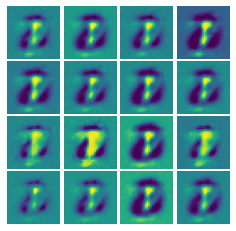

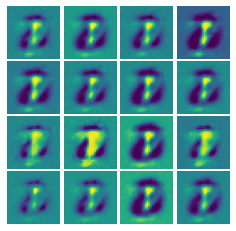

In [7]:
# TODO: Launch this on Google Colab
D = discriminator(gan_type=GAN_TYPE.OOD).to(DEVICE)
G = generator().to(DEVICE)
# Training with Loss Tracker (for debugging)
logger = Logger(10000)

g_d_steps_ratios = 2
hp_set = [HParam(0.1, 1, 1), HParam(0.2,1,1), HParam(0.1, 0.2, 0.2), HParam(0.2,0.5, 0.5)]
logger_max_iter = 2500
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
ind_train_loader = mnist_dset_dict['train_set_ind_loader']
ood_train_loader = mnist_dset_dict['train_set_ood_loader']
gan_trainer(ind_train_loader, D, G, D_solver, G_solver,
            discriminator_loss, generator_loss, g_d_ratio=g_d_steps_ratios,
            gan_type=GAN_TYPE.OOD, show_every=100,ood_loader=ood_train_loader,logger=logger, 
            logger_max_iter=logger_max_iter)
# gan_trainer(mnist_tri_loader, D, G, D_solver, G_solver,
#             discriminator_loss, generator_loss,
#             gan_type=GAN_TYPE.OOD, ood_img_sample=CIFAR10,gd_ls_tracker=GDlsTracker, 
#             gd_ls_track_iter=1000)

In [ ]:
from utils import *
# folder_name = 'mnist_[r=2]/'
folder_name = ''
# logger.plt_ls(save_fname=folder_name+'g_loss_mnist', num_iter=logger_max_iter*g_d_steps_ratios, type=GD.G)
# logger.plt_ls(save_fname=folder_name+'d_loss_mnist', num_iter=logger_max_iter, type=GD.D)
logger.plt_ls(save_fname=folder_name+'g_loss_mnist', num_iter=4640, type=GD.G)
logger.plt_ls(save_fname=folder_name+'d_loss_mnist', num_iter=2320, type=GD.D)

### OOD GANs training with hyperparameter tuning (Small scale)


In [4]:
from utils import *
from trainers.ood_gan_trainer import *

[0] Trial 0 succeeds. Training resumes.
Iter: 0, D: 3.824, G:-0.7663


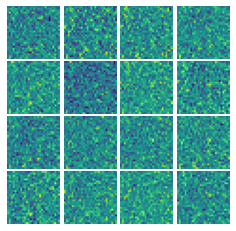


[1] Trial 0 succeeds. Training resumes.
[2] Trial 0 succeeds. Training resumes.
[3] Trial 0 succeeds. Training resumes.
[4] Trial 0 succeeds. Training resumes.
[5] Trial 0 succeeds. Training resumes.
[6] Trial 0 succeeds. Training resumes.
[7] Trial 0 succeeds. Training resumes.
[8] Trial 0 succeeds. Training resumes.
[9] Trial 0 succeeds. Training resumes.
[10] Trial 0 succeeds. Training resumes.
[11] Trial 0 succeeds. Training resumes.
[12] Trial 0 succeeds. Training resumes.
[13] Trial 0 succeeds. Training resumes.
[14] Trial 0 succeeds. Training resumes.
[15] Trial 0 succeeds. Training resumes.
[16] Trial 0 succeeds. Training resumes.
[17] Trial 0 succeeds. Training resumes.
[18] Trial 0 succeeds. Training resumes.
[19] Trial 0 succeeds. Training resumes.
[20] Trial 0 succeeds. Training resumes.
[21] Trial 0 succeeds. Training resumes.
[22] Trial 0 succeeds. Training resumes.
[23] Trial 0 succeeds. Training resumes.
[24] Trial 0 succeeds. Training resumes.
[25] Trial 0 succeeds. T

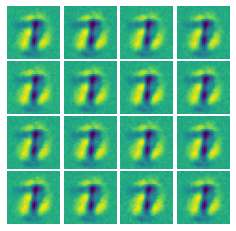


[101] Trial 0 succeeds. Training resumes.
[102] Trial 0 succeeds. Training resumes.
[103] Trial 0 succeeds. Training resumes.
[104] Trial 0 succeeds. Training resumes.
[105] Trial 0 succeeds. Training resumes.
[106] Trial 0 succeeds. Training resumes.
[107] Trial 0 succeeds. Training resumes.
[108] Trial 0 succeeds. Training resumes.
[109] Trial 0 succeeds. Training resumes.
[110] Trial 0 succeeds. Training resumes.
[111] Trial 0 succeeds. Training resumes.
[112] Trial 0 succeeds. Training resumes.
[113] Trial 0 succeeds. Training resumes.
[114] Trial 0 succeeds. Training resumes.
[115] Trial 0 succeeds. Training resumes.
[116] Trial 0 succeeds. Training resumes.
[117] Trial 0 succeeds. Training resumes.
[118] Trial 0 succeeds. Training resumes.
[119] Trial 0 succeeds. Training resumes.
[120] Trial 0 succeeds. Training resumes.
[121] Trial 0 succeeds. Training resumes.
[122] Trial 0 succeeds. Training resumes.
[123] Trial 0 succeeds. Training resumes.
[124] Trial 0 succeeds. Training 

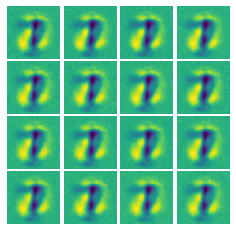


[201] Trial 0 succeeds. Training resumes.
[202] Trial 0 succeeds. Training resumes.
[203] Trial 0 succeeds. Training resumes.
[204] Trial 0 succeeds. Training resumes.
[205] Trial 0 succeeds. Training resumes.
[206] Trial 0 succeeds. Training resumes.
[207] Trial 0 succeeds. Training resumes.
[208] Trial 0 succeeds. Training resumes.
[209] Trial 0 succeeds. Training resumes.
[210] Trial 0 succeeds. Training resumes.
[211] Trial 0 succeeds. Training resumes.
[212] Trial 0 succeeds. Training resumes.
[213] Trial 0 succeeds. Training resumes.
[214] Trial 0 succeeds. Training resumes.
[215] Trial 0 succeeds. Training resumes.
[216] Trial 0 succeeds. Training resumes.
[217] Trial 0 succeeds. Training resumes.
[218] Trial 0 succeeds. Training resumes.
[219] Trial 0 succeeds. Training resumes.
[220] Trial 0 succeeds. Training resumes.
[221] Trial 0 succeeds. Training resumes.
[222] Trial 0 succeeds. Training resumes.
[223] Trial 0 succeeds. Training resumes.
[224] Trial 0 succeeds. Training 

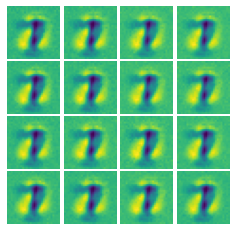


[301] Trial 0 succeeds. Training resumes.
[302] Trial 0 succeeds. Training resumes.
[303] Trial 0 succeeds. Training resumes.
[304] Trial 0 succeeds. Training resumes.
[305] Trial 0 succeeds. Training resumes.
[306] Trial 0 succeeds. Training resumes.
[307] Trial 0 succeeds. Training resumes.
[308] Trial 0 succeeds. Training resumes.
[309] Trial 0 succeeds. Training resumes.
[310] Trial 0 succeeds. Training resumes.
[311] Trial 0 succeeds. Training resumes.
[312] Trial 0 succeeds. Training resumes.
[313] Trial 0 succeeds. Training resumes.
[314] Trial 0 succeeds. Training resumes.
[315] Trial 0 succeeds. Training resumes.
[316] Trial 0 succeeds. Training resumes.
[317] Trial 0 succeeds. Training resumes.
[318] Trial 0 succeeds. Training resumes.
[319] Trial 0 succeeds. Training resumes.
[320] Trial 0 succeeds. Training resumes.
[321] Trial 0 succeeds. Training resumes.
[322] Trial 0 succeeds. Training resumes.
[323] Trial 0 succeeds. Training resumes.
[324] Trial 0 succeeds. Training 

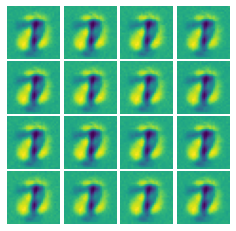


[401] Trial 0 succeeds. Training resumes.
[402] Trial 0 succeeds. Training resumes.
[403] Trial 0 succeeds. Training resumes.
[404] Trial 0 succeeds. Training resumes.
[405] Trial 0 succeeds. Training resumes.
[406] Trial 0 succeeds. Training resumes.
[407] Trial 0 succeeds. Training resumes.
[408] Trial 0 succeeds. Training resumes.
[409] Trial 0 succeeds. Training resumes.
[410] Trial 0 succeeds. Training resumes.
[411] Trial 0 succeeds. Training resumes.
[412] Trial 0 succeeds. Training resumes.
[413] Trial 0 succeeds. Training resumes.
[414] Trial 0 succeeds. Training resumes.
[415] Trial 0 succeeds. Training resumes.
[416] Trial 0 succeeds. Training resumes.
[417] Trial 0 succeeds. Training resumes.
[418] Trial 0 succeeds. Training resumes.
[419] Trial 0 succeeds. Training resumes.
[420] Trial 0 succeeds. Training resumes.
[421] Trial 0 succeeds. Training resumes.
[422] Trial 0 succeeds. Training resumes.
[423] Trial 0 succeeds. Training resumes.
[424] Trial 0 succeeds. Training 

In [7]:
# TODO: Launch this on Google Colab
D = discriminator(gan_type=GAN_TYPE.OOD).to(DEVICE)
G = generator().to(DEVICE)
# Training with Logger (for debugging)
logger = Logger(10000)

g_d_steps_ratios = 1
# hp_set = [HParam(0.1, 1, 1), HParam(0.2,1,1), HParam(0.1, 0.2, 0.2), HParam(0.2,0.5, 0.5)]
logger_max_iter = 500
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
ind_train_loader = mnist_dset_dict['train_set_ind_loader']
ood_train_loader = mnist_dset_dict['train_set_ood_loader']

ood_gan_trainer(ind_loader=ind_train_loader,
                ood_loader=ood_train_loader, 
                D=D, 
                G=G, 
                D_solver=D_solver, 
                G_solver=G_solver, 
                discriminator_loss=discriminator_loss,
                generator_loss=generator_loss, 
                img_info={'H':28,'W':28,'C':1}, 
                backbone=GAN_BACKBONE.FC, 
                checkpoint=None, 
                checkpoint_save_addr=None, 
                hp=HParam(),
                g_d_ratio=g_d_steps_ratios, 
                save_filename=None, 
                show_every=100,
                batch_size=128, 
                noise_size=96, 
                num_epochs=10, 
                logger=logger, 
                logger_max_iter=logger_max_iter)


# gan_trainer(ind_train_loader, D, G, D_solver, G_solver,
#             discriminator_loss, generator_loss, g_d_ratio=g_d_steps_ratios,
#             gan_type=GAN_TYPE.OOD, show_every=100,ood_loader=ood_train_loader,logger=logger_1, 
#             logger_max_iter=logger_max_iter)

In [18]:
from utils import *

In [20]:
logger1 = Logger(10000)
logger1.d_zsl_fake = logger.d_zsl_fake
logger1.d_zsl_ood = logger.d_zsl_ood
logger1.d_ind_ce = logger.d_ind_ce

logger1.g_n_zsl_fake = logger.g_n_zsl_fake
# g_n_zsl_fake = [-elt for elt in g_zsl_fake]
logger1.g_n_dist_fake_ind = logger.g_n_dist_fake_ind
logger1.g_dist_fake_ood = logger.g_dist_fake_ood

ic| 'The total loss of G and D can be accessed now.'


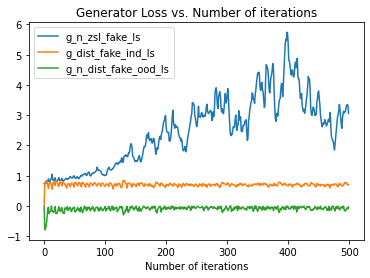

ic| 'The total loss of G and D can be accessed now.'


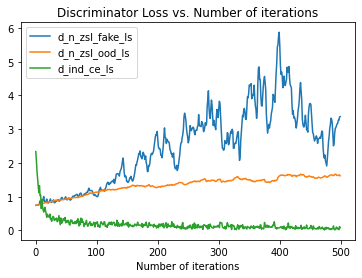

In [22]:
from utils import *
logger.plt_ls(save_fname='ood_gan_g_500', num_iter=500, type=GD.G)
logger.plt_ls(save_fname='ood_gan_d_500', num_iter=500, type=GD.D)

In [10]:
# d_zsl_fake = logger.d_zsl_fake
# d_zsl_ood = logger.d_zsl_ood
# d_ind_ce = logger.d_ind_ce

# g_zsl_fake = logger.g_n_zsl_fake
# g_n_zsl_fake = [-elt for elt in g_zsl_fake]
# g_n_dist_fake_ind = logger.g_n_dist_fake_ind
# g_dist_fake_ood = logger.g_dist_fake_ood

In [24]:
ic(torch.mean(torch.tensor(logger.d_ind_ce)))

ic| torch.mean(torch.tensor(logger.d_ind_ce)): tensor(0.1764)


tensor(0.1764)

### Large Scale OOD GANs Training with Logger

#### Discriminator pretraining

In [27]:
from trainers.trainer import train

In [28]:
D = discriminator(gan_type=GAN_TYPE.OOD).to(DEVICE)
ind_train_loader = mnist_dset_dict['train_set_ind_loader']
ind_val_loader = mnist_dset_dict['val_set_ind_loader']
train(D,ind_train_loader,ind_val_loader, num_epoch=1)

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

Epoch  # 1 | training loss: 0.8636623258370698               | training acc: 0.8384175397626862
Epoch  # 1 | validation loss: 0.23687710718084604               | validation acc: 0.9367141272189349


In [29]:
PRE_D_PATH = '../checkpoint/pretrained_D.pt'
torch.save(D, PRE_D_PATH)

#### OOD Training

In [30]:
from utils import *
from trainers.ood_gan_trainer import *

In [31]:
logger = Logger(10000)

[0] Trial 0 succeeds. Training resumes.
Iter: 0, D: 3.533, G:-0.7777


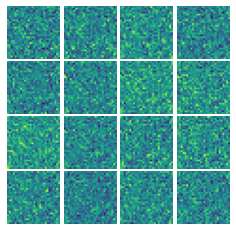


[1] Trial 0 succeeds. Training resumes.
[2] Trial 0 succeeds. Training resumes.
[3] Trial 0 succeeds. Training resumes.
[4] Trial 0 succeeds. Training resumes.
[5] Trial 0 succeeds. Training resumes.
[6] Trial 0 succeeds. Training resumes.
[7] Trial 0 succeeds. Training resumes.
[8] Trial 0 succeeds. Training resumes.
[9] Trial 0 succeeds. Training resumes.
[10] Trial 0 succeeds. Training resumes.
[11] Trial 0 succeeds. Training resumes.
[12] Trial 0 succeeds. Training resumes.
[13] Trial 0 succeeds. Training resumes.
[14] Trial 0 succeeds. Training resumes.
[15] Trial 0 succeeds. Training resumes.
[16] Trial 0 succeeds. Training resumes.
[17] Trial 0 succeeds. Training resumes.
[18] Trial 0 succeeds. Training resumes.
[19] Trial 0 succeeds. Training resumes.
[20] Trial 0 succeeds. Training resumes.
[21] Trial 0 succeeds. Training resumes.
[22] Trial 0 succeeds. Training resumes.
[23] Trial 0 succeeds. Training resumes.
[24] Trial 0 succeeds. Training resumes.
[25] Trial 0 succeeds. T

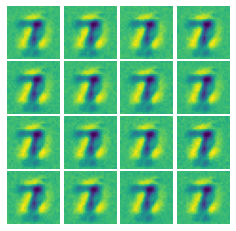


[101] Trial 0 succeeds. Training resumes.
[102] Trial 0 succeeds. Training resumes.
[103] Trial 0 succeeds. Training resumes.
[104] Trial 0 succeeds. Training resumes.
[105] Trial 0 succeeds. Training resumes.
[106] Trial 0 succeeds. Training resumes.
[107] Trial 0 succeeds. Training resumes.
[108] Trial 0 succeeds. Training resumes.
[109] Trial 0 succeeds. Training resumes.
[110] Trial 0 succeeds. Training resumes.
[111] Trial 0 succeeds. Training resumes.
[112] Trial 0 succeeds. Training resumes.
[113] Trial 0 succeeds. Training resumes.
[114] Trial 0 succeeds. Training resumes.
[115] Trial 0 succeeds. Training resumes.
[116] Trial 0 succeeds. Training resumes.
[117] Trial 0 succeeds. Training resumes.
[118] Trial 0 succeeds. Training resumes.
[119] Trial 0 succeeds. Training resumes.
[120] Trial 0 succeeds. Training resumes.
[121] Trial 0 succeeds. Training resumes.
[122] Trial 0 succeeds. Training resumes.
[123] Trial 0 succeeds. Training resumes.
[124] Trial 0 succeeds. Training 

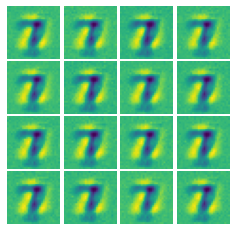


[201] Trial 0 succeeds. Training resumes.
[202] Trial 0 succeeds. Training resumes.
[203] Trial 0 succeeds. Training resumes.
[204] Trial 0 succeeds. Training resumes.
[205] Trial 0 succeeds. Training resumes.
[206] Trial 0 succeeds. Training resumes.
[207] Trial 0 succeeds. Training resumes.
[208] Trial 0 succeeds. Training resumes.
[209] Trial 0 succeeds. Training resumes.
[210] Trial 0 succeeds. Training resumes.
[211] Trial 0 succeeds. Training resumes.
[212] Trial 0 succeeds. Training resumes.
[213] Trial 0 succeeds. Training resumes.
[214] Trial 0 succeeds. Training resumes.
[215] Trial 0 succeeds. Training resumes.
[216] Trial 0 succeeds. Training resumes.
[217] Trial 0 succeeds. Training resumes.
[218] Trial 0 succeeds. Training resumes.
[219] Trial 0 succeeds. Training resumes.
[220] Trial 0 succeeds. Training resumes.
[221] Trial 0 succeeds. Training resumes.
[222] Trial 0 succeeds. Training resumes.
[223] Trial 0 succeeds. Training resumes.
[224] Trial 0 succeeds. Training 

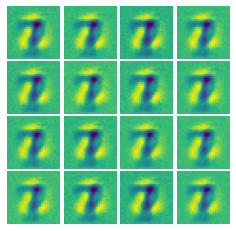


[301] Trial 0 succeeds. Training resumes.
[302] Trial 0 succeeds. Training resumes.
[303] Trial 0 succeeds. Training resumes.
[304] Trial 0 succeeds. Training resumes.
[305] Trial 0 succeeds. Training resumes.
[306] Trial 0 succeeds. Training resumes.
[307] Trial 0 succeeds. Training resumes.
[308] Trial 0 succeeds. Training resumes.
[309] Trial 0 succeeds. Training resumes.
[310] Trial 0 succeeds. Training resumes.
[311] Trial 0 succeeds. Training resumes.
[312] Trial 0 succeeds. Training resumes.
[313] Trial 0 succeeds. Training resumes.
[314] Trial 0 succeeds. Training resumes.
[315] Trial 0 succeeds. Training resumes.
[316] Trial 0 succeeds. Training resumes.
[317] Trial 0 succeeds. Training resumes.
[318] Trial 0 succeeds. Training resumes.
[319] Trial 0 succeeds. Training resumes.
[320] Trial 0 succeeds. Training resumes.
[321] Trial 0 succeeds. Training resumes.
[322] Trial 0 succeeds. Training resumes.
[323] Trial 0 succeeds. Training resumes.
[324] Trial 0 succeeds. Training 

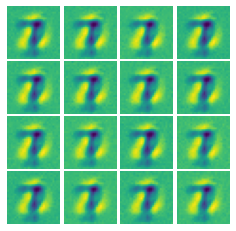


[401] Trial 0 succeeds. Training resumes.
[402] Trial 0 succeeds. Training resumes.
[403] Trial 0 succeeds. Training resumes.
[404] Trial 0 succeeds. Training resumes.
[405] Trial 0 succeeds. Training resumes.
[406] Trial 0 succeeds. Training resumes.
[407] Trial 0 succeeds. Training resumes.
[408] Trial 0 succeeds. Training resumes.
[409] Trial 0 succeeds. Training resumes.
[410] Trial 0 succeeds. Training resumes.
[411] Trial 0 succeeds. Training resumes.
[412] Trial 0 succeeds. Training resumes.
[413] Trial 0 succeeds. Training resumes.
[414] Trial 0 succeeds. Training resumes.
[415] Trial 0 succeeds. Training resumes.
[416] Trial 0 succeeds. Training resumes.
[417] Trial 0 succeeds. Training resumes.
[418] Trial 0 succeeds. Training resumes.
[419] Trial 0 succeeds. Training resumes.
[420] Trial 0 succeeds. Training resumes.
[421] Trial 0 succeeds. Training resumes.
[422] Trial 0 succeeds. Training resumes.
[423] Trial 0 succeeds. Training resumes.
[424] Trial 0 succeeds. Training 

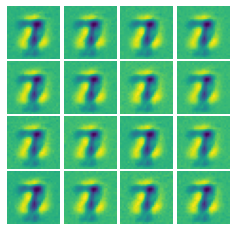


[501] Trial 0 succeeds. Training resumes.
[502] Trial 0 succeeds. Training resumes.
[503] Trial 0 succeeds. Training resumes.
[504] Trial 0 succeeds. Training resumes.
[505] Trial 0 succeeds. Training resumes.
[506] Trial 0 succeeds. Training resumes.
[507] Trial 0 succeeds. Training resumes.
[508] Trial 0 succeeds. Training resumes.
[509] Trial 0 succeeds. Training resumes.
[510] Trial 0 succeeds. Training resumes.
[511] Trial 0 succeeds. Training resumes.
[512] Trial 0 succeeds. Training resumes.
[513] Trial 0 succeeds. Training resumes.
[514] Trial 0 succeeds. Training resumes.
[515] Trial 0 succeeds. Training resumes.
[516] Trial 0 succeeds. Training resumes.
[517] Trial 0 succeeds. Training resumes.
[518] Trial 0 succeeds. Training resumes.
[519] Trial 0 succeeds. Training resumes.
[520] Trial 0 succeeds. Training resumes.
[521] Trial 0 succeeds. Training resumes.
[522] Trial 0 succeeds. Training resumes.
[523] Trial 0 succeeds. Training resumes.
[524] Trial 0 succeeds. Training 

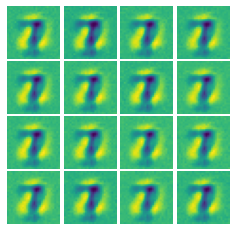


[601] Trial 0 succeeds. Training resumes.
[602] Trial 0 succeeds. Training resumes.
[603] Trial 0 succeeds. Training resumes.
[604] Trial 0 succeeds. Training resumes.
[605] Trial 0 succeeds. Training resumes.
[606] Trial 0 succeeds. Training resumes.
[607] Trial 0 succeeds. Training resumes.
[608] Trial 0 succeeds. Training resumes.
[609] Trial 0 succeeds. Training resumes.
[610] Trial 0 succeeds. Training resumes.
[611] Trial 0 succeeds. Training resumes.
[612] Trial 0 succeeds. Training resumes.
[613] Trial 0 succeeds. Training resumes.
[614] Trial 0 succeeds. Training resumes.
[615] Trial 0 succeeds. Training resumes.
[616] Trial 0 succeeds. Training resumes.
[617] Trial 0 succeeds. Training resumes.
[618] Trial 0 succeeds. Training resumes.
[619] Trial 0 succeeds. Training resumes.
[620] Trial 0 succeeds. Training resumes.
[621] Trial 0 succeeds. Training resumes.
[622] Trial 0 succeeds. Training resumes.
[623] Trial 0 succeeds. Training resumes.
[624] Trial 0 succeeds. Training 

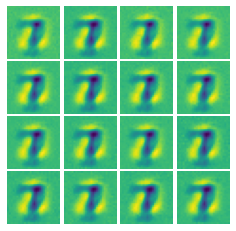


[701] Trial 0 succeeds. Training resumes.
[702] Trial 0 succeeds. Training resumes.
[703] Trial 0 succeeds. Training resumes.
[704] Trial 0 succeeds. Training resumes.
[705] Trial 0 succeeds. Training resumes.
[706] Trial 0 succeeds. Training resumes.
[707] Trial 0 succeeds. Training resumes.
[708] Trial 0 succeeds. Training resumes.
[709] Trial 0 succeeds. Training resumes.
[710] Trial 0 succeeds. Training resumes.
[711] Trial 0 succeeds. Training resumes.
[712] Trial 0 succeeds. Training resumes.
[713] Trial 0 succeeds. Training resumes.
[714] Trial 0 succeeds. Training resumes.
[715] Trial 0 succeeds. Training resumes.
[716] Trial 0 succeeds. Training resumes.
[717] Trial 0 succeeds. Training resumes.
[718] Trial 0 succeeds. Training resumes.
[719] Trial 0 succeeds. Training resumes.
[720] Trial 0 succeeds. Training resumes.
[721] Trial 0 succeeds. Training resumes.
[722] Trial 0 succeeds. Training resumes.
[723] Trial 0 succeeds. Training resumes.
[724] Trial 0 succeeds. Training 

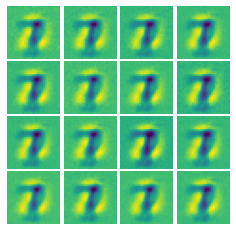


[801] Trial 0 succeeds. Training resumes.
[802] Trial 0 succeeds. Training resumes.
[803] Trial 0 succeeds. Training resumes.
[804] Trial 0 succeeds. Training resumes.
[805] Trial 0 succeeds. Training resumes.
[806] Trial 0 succeeds. Training resumes.
[807] Trial 0 succeeds. Training resumes.
[808] Trial 0 succeeds. Training resumes.
[809] Trial 0 succeeds. Training resumes.
[810] Trial 0 succeeds. Training resumes.
[811] Trial 0 succeeds. Training resumes.
[812] Trial 0 succeeds. Training resumes.
[813] Trial 0 succeeds. Training resumes.
[814] Trial 0 succeeds. Training resumes.
[815] Trial 0 succeeds. Training resumes.
[816] Trial 0 succeeds. Training resumes.
[817] Trial 0 succeeds. Training resumes.
[818] Trial 0 succeeds. Training resumes.
[819] Trial 0 succeeds. Training resumes.
[820] Trial 0 succeeds. Training resumes.
[821] Trial 0 succeeds. Training resumes.
[822] Trial 0 succeeds. Training resumes.
[823] Trial 0 succeeds. Training resumes.
[824] Trial 0 succeeds. Training 

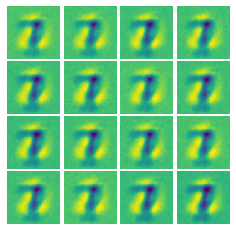


[901] Trial 0 succeeds. Training resumes.
[902] Trial 0 succeeds. Training resumes.
[903] Trial 0 succeeds. Training resumes.
[904] Trial 0 succeeds. Training resumes.
[905] Trial 0 succeeds. Training resumes.
[906] Trial 0 succeeds. Training resumes.
[907] Trial 0 succeeds. Training resumes.
[908] Trial 0 succeeds. Training resumes.
[909] Trial 0 succeeds. Training resumes.
[910] Trial 0 succeeds. Training resumes.
[911] Trial 0 succeeds. Training resumes.
[912] Trial 0 succeeds. Training resumes.
[913] Trial 0 succeeds. Training resumes.
[914] Trial 0 succeeds. Training resumes.
[915] Trial 0 succeeds. Training resumes.
[916] Trial 0 succeeds. Training resumes.
[917] Trial 0 succeeds. Training resumes.
[918] Trial 0 succeeds. Training resumes.
[919] Trial 0 succeeds. Training resumes.
[920] Trial 0 succeeds. Training resumes.
[921] Trial 0 succeeds. Training resumes.
[922] Trial 0 succeeds. Training resumes.
[923] Trial 0 succeeds. Training resumes.
[924] Trial 0 succeeds. Training 

In [35]:
D = discriminator(gan_type=GAN_TYPE.OOD).to(DEVICE)
G = generator().to(DEVICE)
# Training with Logger (for debugging)
logger = Logger(10000)

g_d_steps_ratios = 1
# hp_set = [HParam(0.1, 1, 1), HParam(0.2,1,1), HParam(0.1, 0.2, 0.2), HParam(0.2,0.5, 0.5)]
# logger_max_iter = 500
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
ind_train_loader = mnist_dset_dict['train_set_ind_loader']
ood_train_loader = mnist_dset_dict['train_set_ood_loader']
ood_gan_trainer(ind_loader=ind_train_loader,
                ood_loader=ood_train_loader, 
                D=D, 
                G=G, 
                D_solver=D_solver, 
                G_solver=G_solver, 
                discriminator_loss=discriminator_loss,
                generator_loss=generator_loss, 
                img_info={'H':28,'W':28,'C':1}, 
                backbone=GAN_BACKBONE.FC, 
                checkpoint=None, 
                checkpoint_save_addr=None, 
                pretrained_D=PRE_D_PATH,
                hp=HParam(),
                g_d_ratio=g_d_steps_ratios, 
                save_filename=None, 
                show_every=100,
                batch_size=128, 
                noise_size=96, 
                num_epochs=10, 
                logger=logger, 
                logger_max_iter=1000)

ic| 'The total loss of G and D can be accessed now.'


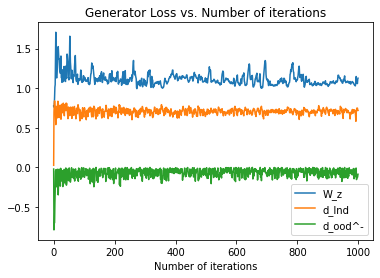

ic| 'The total loss of G and D can be accessed now.'


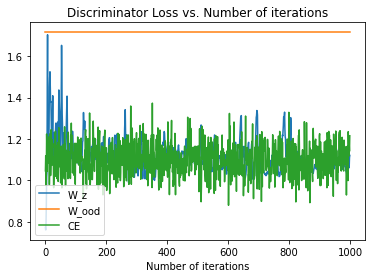

In [36]:
from utils import *
logger.plt_ls(save_fname='g_50', num_iter=1000, type=GD.G)
logger.plt_ls(save_fname='d_50', num_iter=1000, type=GD.D)

In [34]:
print(logger.d_zsl_ood)

[tensor(1.8124), tensor(1.8124), tensor(1.8124), tensor(1.8124), tensor(1.8124), tensor(1.8124), tensor(1.8124), tensor(1.8124), tensor(1.8124), tensor(1.8124)]


### Random Sample Distances (Debugging)

Goals: we want the random generated images at first few iterations to be away from InD data.

Problems:
-  How to set the threshold?
-  Different metrics have different magnitude of threshold values.

In [ ]:
G = generator().to(DEVICE)
cor_ls = []
ind_batch = next(iter(mnist_tri_loader))[0].squeeze().reshape((128, -1))
# ic(ind_batch.shape)
for trial in range(100):
    g_fake_seed = sample_noise(128, 96, dtype=torch.float32, device=DEVICE)
    fake_images = G(g_fake_seed).detach()
    # ic(fake_images.shape)
    cor_ls.append(get_dist_metric(fake_images, ind_batch, 32, type=DIST_TYPE.COR))
ic(cor_ls)


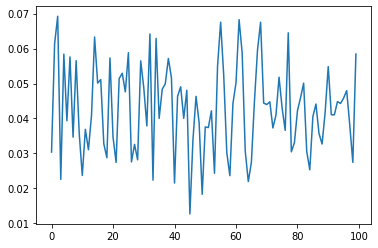

TypeError: mean(): argument 'input' (position 1) must be Tensor, not list

In [34]:
plt.plot(range(100), cor_ls)
plt.show()
plt.close()

ic(torch.mean(cor_ls))